In [2]:
import os 
import pandas as pd
import tensorflow as tf
import numpy as np
import re
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

/Users/dilshantharushika/miniforge3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df= pd.read_csv('IMDB Dataset.csv')

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [6]:
df.loc[df['sentiment']=='positive','sentiment']=1
df.loc[df['sentiment']=='negative','sentiment']=0

In [7]:
df['sentiment']=df['sentiment'].astype(int)

In [8]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  
    return text
df['review'] = df['review'].apply(clean_text)   

In [9]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [10]:
X =df['review']
y= df['sentiment']

In [11]:
len(set(" ".join(df['review']).split()))

469119

In [12]:
MAX_FEATURES = 250000

In [13]:
df['text_length'] = df['review'].apply(lambda x: len(x.split()))

# Get the 90th or 95th percentile of the text lengths
percentile_90 = np.percentile(df['text_length'], 90)
percentile_95 = np.percentile(df['text_length'], 95)

print(f"90th Percentile of text length: {percentile_90}")
print(f"95th Percentile of text length: {percentile_95}")

90th Percentile of text length: 443.0
95th Percentile of text length: 580.0


In [14]:
OUTPUT_SEQUENCE_LENGTH = int(percentile_95) + 20 

In [15]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
                               output_mode='int')

In [16]:
vectorizer.adapt(X.values)

In [17]:
vectorized_text = vectorizer(X.values)

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=160000) 
dataset = dataset.batch(16) 
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [19]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [20]:
model = Sequential()

model.add(Embedding(input_dim=MAX_FEATURES+1, output_dim=32, input_length=OUTPUT_SEQUENCE_LENGTH))

model.add(Bidirectional(LSTM(units=64, activation='tanh', return_sequences=False)))

model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0002),  
    loss='binary_crossentropy',  
    metrics=['accuracy']        
)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 32)           8000032   
                                                                 
 bidirectional (Bidirection  (None, 128)               49664     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8060065 (30.75 MB)
Trainable params: 8060065 (30.75 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [21]:
history = model.fit(train, validation_data=val, epochs=5)


test_loss, test_accuracy = model.evaluate(test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/5
2187/2187 [==============================] - 376s 171ms/step - loss: 0.4313 - accuracy: 0.7825 - val_loss: 0.2360 - val_accuracy: 0.9109
Epoch 2/5
2187/2187 [==============================] - 380s 174ms/step - loss: 0.2192 - accuracy: 0.9190 - val_loss: 0.1520 - val_accuracy: 0.9497
Epoch 3/5
2187/2187 [==============================] - 381s 174ms/step - loss: 0.1779 - accuracy: 0.9365 - val_loss: 0.1147 - val_accuracy: 0.9628
Epoch 4/5
2187/2187 [==============================] - 377s 172ms/step - loss: 0.1221 - accuracy: 0.9591 - val_loss: 0.0702 - val_accuracy: 0.9798
Epoch 5/5
312/312 [==============================] - 10s 31ms/step - loss: 0.0675 - accuracy: 0.9786
Test Accuracy: 97.86%


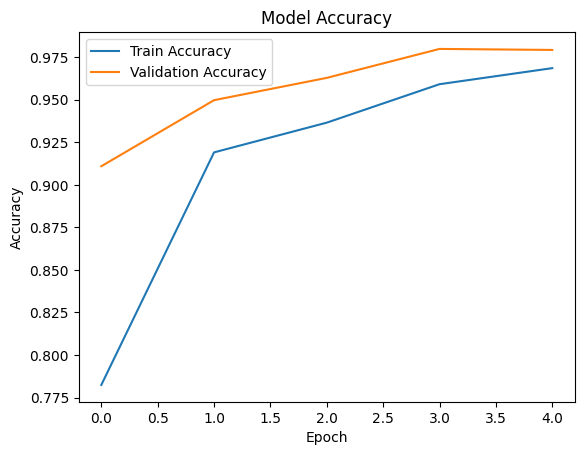

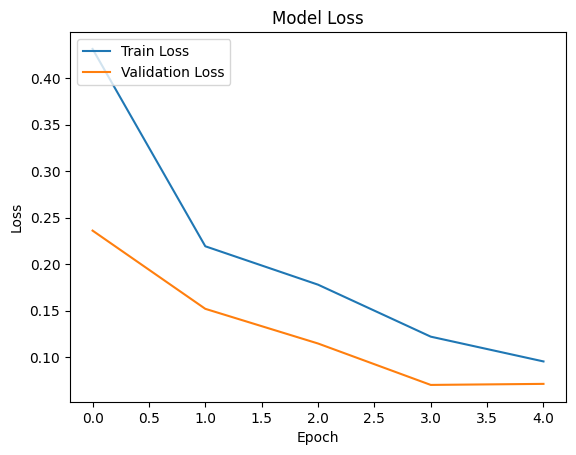

In [24]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [26]:
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


312/312 [==============================] - 10s 31ms/step - loss: 0.0625 - accuracy: 0.9824
Test Accuracy: 98.24%


In [28]:
model.save('movie_review_classifier.keras')


In [30]:
sample_reviews = ["This was the best movie I've ever seen!", "The plot was boring and predictable."]
predictions = model.predict(vectorizer(sample_reviews))

for review, pred in zip(sample_reviews, predictions):
    sentiment = "Positive" if pred > 0.5 else "Negative"
    print(f"Review: {review} - Predicted Sentiment: {sentiment} ({pred[0] * 100:.2f}%)")


1/1 [==============================] - 0s 35ms/step
Review: This was the best movie I've ever seen! - Predicted Sentiment: Positive (73.22%)
Review: The plot was boring and predictable. - Predicted Sentiment: Negative (2.29%)
